In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

Fix the random seed:

In [2]:
# Seed
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
class RegressionDataset(torch.utils.data.Dataset):
    """Simple regression dataset."""

    def __init__(self, timesteps, num_samples, mode):
        """Linear relation between input and output"""
        self.num_samples = num_samples  # number of generated samples
        feature_lst = []  # store each generated sample in a list

        # generate linear functions one by one
        for idx in range(num_samples):
            end = float(torch.rand(1))  # random final point
            lin_vec = torch.linspace(
                start=0.0, end=end, steps=timesteps
            )  # generate linear function from 0 to end
            feature = lin_vec.view(timesteps, 1)
            feature_lst.append(feature)  # add sample to list

        self.features = torch.stack(feature_lst, dim=1)  # convert list to tensor

        # option to generate linear function or square-root function
        if mode == "linear":
            self.labels = self.features * 1

        elif mode == "sqrt":
            slope = float(torch.rand(1))
            self.labels = torch.sqrt(self.features * slope)

        else:
            raise NotImplementedError("'linear', 'sqrt'")

    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""
        return self.features[:, idx, :], self.labels[:, idx, :]

To see what a random sample looks like, run the following code-block:

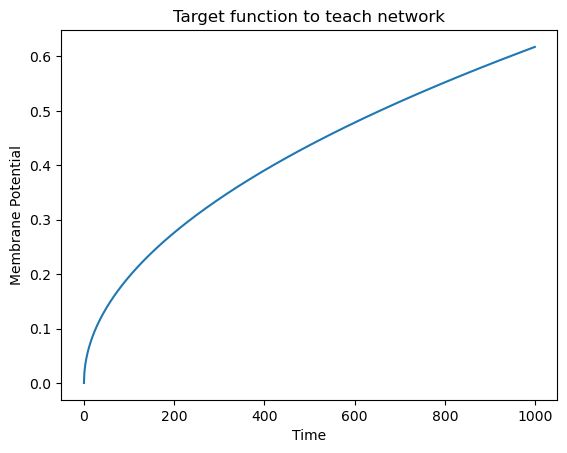

In [4]:
num_steps = 1000
num_samples = 1
mode = "sqrt"  # 'linear' or 'sqrt'

# generate a single data sample
dataset = RegressionDataset(timesteps=num_steps, num_samples=num_samples, mode=mode)

# plot
sample = dataset.labels[:, 0, 0]
plt.plot(sample)
plt.title("Target function to teach network")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
plt.show()

## 2.2 Create DataLoader

The Dataset objects created above load data into memory, and the DataLoader will serve it up in batches. DataLoaders in PyTorch are a handy interface for passing data into a network. They return an iterator divided up into mini-batches of size ``batch_size``.

In [5]:
batch_size = 1  # only one sample to learn
dataloader = torch.utils.data.DataLoader(
    dataset=dataset, batch_size=batch_size, drop_last=True
)

# 3. Construct Model

Let us try a simple network using only leaky integrate-and-fire layers without recurrence.
Subsequent tutorials will show how to use more complex neuron types with higher-order recurrence.
These architectures should work just fine, if there is no strong time dependency in the data, i.e., the next time step has weak dependence on the previous one.

A few notes on the architecture below:

* Setting `learn_beta=True` enables the decay rate `beta` to be a learnable parameter
* Each neuron has a unique, and randomly initialized threshold and decay rate
* The output layer has the reset mechanism disabled by setting `reset_mechanism="none"` as we will not use any output spikes

In [6]:
class Net(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps, hidden):
        super().__init__()

        self.timesteps = timesteps  # number of time steps to simulate the network
        self.hidden = hidden  # number of hidden neurons
        spike_grad = surrogate.fast_sigmoid()  # surrogate gradient function

        # randomly initialize decay rate and threshold for layer 1
        beta_in = torch.rand(self.hidden)
        thr_in = torch.rand(self.hidden)

        # layer 1
        self.fc_in = torch.nn.Linear(in_features=1, out_features=self.hidden)
        self.lif_in = snn.Leaky(
            beta=beta_in, threshold=thr_in, learn_beta=True, spike_grad=spike_grad
        )

        # randomly initialize decay rate and threshold for layer 2
        beta_hidden = torch.rand(self.hidden)
        thr_hidden = torch.rand(self.hidden)

        # layer 2
        self.fc_hidden = torch.nn.Linear(
            in_features=self.hidden, out_features=self.hidden
        )
        self.lif_hidden = snn.Leaky(
            beta=beta_hidden,
            threshold=thr_hidden,
            learn_beta=True,
            spike_grad=spike_grad,
        )

        # randomly initialize decay rate for output neuron
        beta_out = torch.rand(1)

        # layer 3: leaky integrator neuron. Note the reset mechanism is disabled and we will disregard output spikes.
        self.fc_out = torch.nn.Linear(in_features=self.hidden, out_features=1)
        self.li_out = snn.Leaky(
            beta=beta_out,
            threshold=1.0,
            learn_beta=True,
            spike_grad=spike_grad,
            reset_mechanism="none",
        )

    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem_1 = self.lif_in.init_leaky()
        mem_2 = self.lif_hidden.init_leaky()
        mem_3 = self.li_out.init_leaky()

        # Empty lists to record outputs
        mem_3_rec = []

        # Loop over
        for step in range(self.timesteps):
            x_timestep = x[step, :, :]

            cur_in = self.fc_in(x_timestep)
            spk_in, mem_1 = self.lif_in(cur_in, mem_1)

            cur_hidden = self.fc_hidden(spk_in)
            spk_hidden, mem_2 = self.li_out(cur_hidden, mem_2)

            cur_out = self.fc_out(spk_hidden)
            _, mem_3 = self.li_out(cur_out, mem_3)

            mem_3_rec.append(mem_3)

        return torch.stack(mem_3_rec)

Instantiate the network below:

In [7]:
hidden = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = Net(timesteps=num_steps, hidden=hidden).to(device)

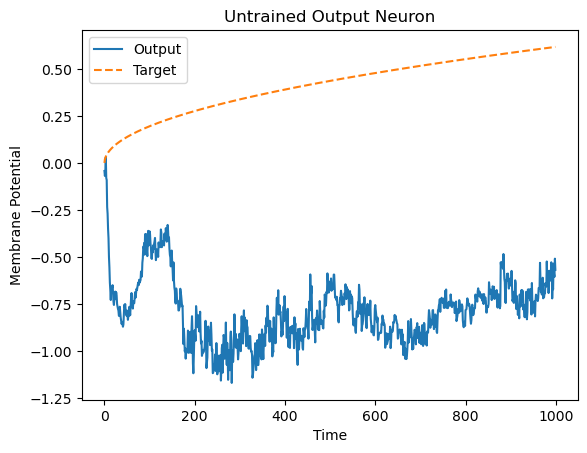

In [8]:
train_batch = iter(dataloader)

# run a single forward-pass
with torch.no_grad():
    for feature, label in train_batch:
        feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
        label = torch.swapaxes(input=label, axis0=0, axis1=1)
        feature = feature.to(device)
        label = label.to(device)
        mem = model(feature)

# plot
plt.plot(mem[:, :, 0].cpu(), label="Output")
plt.plot(label[:, :, 0].cpu(), "--", label="Target")
plt.title("Untrained Output Neuron")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
plt.legend(loc="best")
plt.show()

In [10]:
from Neuronova_Sim.NeuronovaSim import NeuronovaSim

input_size = 1
neurons_per_layer = [hidden, 1]

model = NeuronovaSim(
    chip_topology="FF",
    chip_model="LIF",
    input_size=input_size,
    neuron_number_per_layer=neurons_per_layer,
    taus=62.7e-3,
    thresholds=1.0,
    dt=1e-3,
    device="gpu",
    learn_taus=True,
)

0.0627


Let's observe the behavior of the output neuron before it has been trained and how it compares to the target function:

As the network has not yet been trained, it is unsurprising the membrane potential follows a senseless evolution.

torch.Size([1000, 1, 1])
torch.Size([1000, 1, 1])


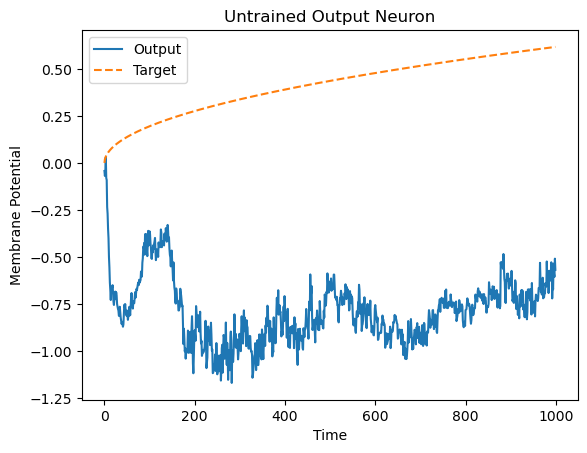

In [11]:
train_batch = iter(dataloader)

# run a single forward-pass
with torch.no_grad():
    for feature, label in train_batch:
        feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
        label = torch.swapaxes(input=label, axis0=0, axis1=1)
        print(feature.shape)
        feature = feature.to(device)
        label = label.to(device)
print(mem.shape)
# plot
plt.plot(mem[:, 0, 0].cpu(), label="Output")
plt.plot(label[:, 0, 0].cpu(), "--", label="Target")
plt.title("Untrained Output Neuron")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
plt.legend(loc="best")
plt.show()

In [12]:

label.shape

torch.Size([1000, 1, 1])

# 4. Construct Training Loop

We call `torch.nn.MSELoss()` to minimize the mean square error between the membrane potential and the target evolution.

We iterate over the same sample of data.

In [13]:
num_iter = 5000  # train for 100 iterations
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()

loss_hist = []  # record loss

# training loop
with tqdm.trange(num_iter) as pbar:
    for _ in pbar:
        train_batch = iter(dataloader)
        minibatch_counter = 0
        loss_epoch = []

        for feature, label in train_batch:
            feature.to(device)
            # forward pass
            mem = model(feature)[3]
            # print(torch.swapaxes(input=mem, axis0=1, axis1=0).shape)
            # print(label.shape)
            loss_val = loss_function(torch.swapaxes(input=mem, axis0=1, axis1=0), label)

            optimizer.zero_grad()  # zero out gradients
            loss_val.backward()  # calculate gradients
            optimizer.step()  # update weights

            # store loss
            loss_hist.append(loss_val.item())
            loss_epoch.append(loss_val.item())
            minibatch_counter += 1

            avg_batch_loss = (
                sum(loss_epoch) / minibatch_counter
            )  # calculate average loss p/epoch
            pbar.set_postfix(loss="%.3e" % avg_batch_loss)  # print loss p/batch

  2%|▏         | 88/5000 [00:17<15:56,  5.13it/s, loss=3.315e-02]


KeyboardInterrupt: 

# 5. Evaluation

In [24]:
loss_function = torch.nn.L1Loss()  # Use L1 loss instead

# pause gradient calculation during evaluation
with torch.no_grad():
    model.eval()

    test_batch = iter(dataloader)
    minibatch_counter = 0
    rel_err_lst = []

    # loop over data samples
    for feature, label in test_batch:

        feature = feature.to(device)
        label = label.to(device)

        # forward-pass
        mem = model(feature)[3]

        # calculate relative error
        rel_err = torch.linalg.norm((mem - label), dim=-1) / torch.linalg.norm(
            label, dim=-1
        )
        rel_err = torch.mean(rel_err[1:, :])

        # calculate loss
        loss_val = loss_function(mem, label)

        # store loss
        loss_hist.append(loss_val.item())
        rel_err_lst.append(rel_err.item())
        minibatch_counter += 1

    mean_L1 = statistics.mean(loss_hist)
    mean_rel = statistics.mean(rel_err_lst)

print(f"{'Mean L1-loss:':<{20}}{mean_L1:1.2e}")
print(f"{'Mean rel. err.:':<{20}}{mean_rel:1.2e}")

Mean L1-loss:       1.18e-04
Mean rel. err.:     inf


/opt/conda/envs/PyTorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([1, 50, 1])) that is different to the input size (torch.Size([50, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Let's plot our results for some visual intuition:

In [ ]:
mem.shape

torch.Size([1, 50, 1])

In [65]:
batch_size

1

In [28]:
mem.shape

torch.Size([50, 1, 1])

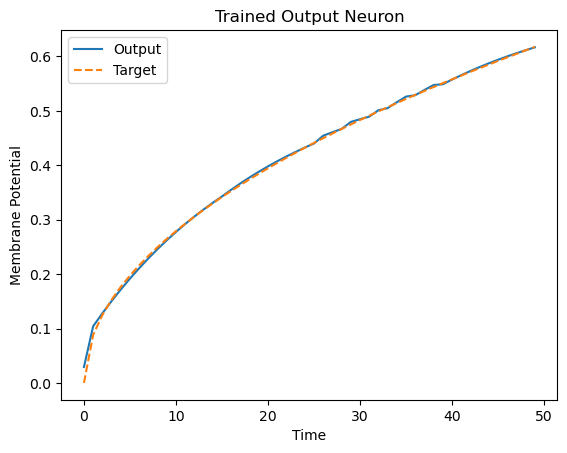

In [29]:
mem = mem.cpu()

label = label.cpu()
plt.title("Trained Output Neuron")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")

for i in range(batch_size):
    # pick a single output neuron, say neuron 0
    out_trace = mem[:, i, 0].cpu()
    target_trace = label[i,:, 0].cpu()

    plt.plot(out_trace, label="Output" if i == 0 else None)
    plt.plot(target_trace, "--", label="Target" if i == 0 else None)

# only label the first iteration to avoid duplicate legend entries
plt.legend(loc="best")
plt.show()

In [39]:
print(" feature:", feature.shape, " label:", label.shape, " mem:", mem.shape)

 feature: torch.Size([50, 1, 1])  label: torch.Size([50, 1, 1])  mem: torch.Size([1, 50, 1])
